In [1]:
import sys
import os
import time
import numpy as np

from utils import *
from rnnmath import *
from sys import stdout
from rnn import *

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.layers import Embedding, LSTM, GRU, Dropout
from keras.models import Model

np.random.seed(2018)
data_folder = "../data"

In [2]:
vocab_size = 8000
vocab = pd.read_table(data_folder + "/vocab.wiki.txt", header=None, sep="\s+", index_col=0, names=['count', 'freq'], )
num_to_word = dict(enumerate(vocab.index[:vocab_size]))
word_to_num = invert_dict(num_to_word)

# calculate loss vocabulary words due to vocab_size
fraction_lost = fraq_loss(vocab, word_to_num, vocab_size)
print("Retained %d words from %d (%.02f%% of all tokens)\n" % (vocab_size, len(vocab), 100*(1-fraction_lost)))

# load training data
sents = load_np_dataset(data_folder + '/wiki-train.txt')
S_train = docs_to_indices(sents, word_to_num, 0, 0)
X_train, D_train = seqs_to_npXY(S_train)

sents = load_np_dataset(data_folder + '/wiki-dev.txt')
S_dev = docs_to_indices(sents, word_to_num, 0, 0)
X_dev, D_dev = seqs_to_npXY(S_dev)

sents = load_np_dataset(data_folder + '/wiki-test.txt')
S_test = docs_to_indices(sents, word_to_num, 0, 0)
X_test, D_test = seqs_to_npXY(S_test)

Retained 8000 words from 9954 (99.34% of all tokens)



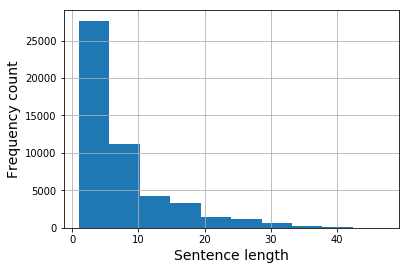

In [4]:
X_len = list(map(lambda x: len(x), X_train))
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(X_len).hist()
plt.xlabel("Sentence length",fontsize=14)
plt.ylabel("Frequency count",fontsize=14)
plt.savefig("SentenceLength.pdf")
plt.show()

In [5]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 20

In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
x_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])
x_dev = pad_sequences(X_dev, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])
x_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])

/home/ramona/anaconda3/envs/mlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ramona/anaconda3/envs/mlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [208]:
vocab_size = 8000
vocab = pd.read_table(data_folder + "/vocab.wiki.txt", header=None, sep="\s+", index_col=0, names=['count', 'freq'], )
num_to_word = dict(enumerate(vocab.index[:vocab_size]))
word_to_num = invert_dict(num_to_word)

# calculate loss vocabulary words due to vocab_size
fraction_lost = fraq_loss(vocab, word_to_num, vocab_size)
print("Retained %d words from %d (%.02f%% of all tokens)\n" % (vocab_size, len(vocab), 100*(1-fraction_lost)))

# load training data
sents = load_np_dataset(data_folder + '/wiki-train.txt')
S_train = docs_to_indices(sents, word_to_num, 0, 0)
X_train, D_train = seqs_to_npXY(S_train)

sents = load_np_dataset(data_folder + '/wiki-dev.txt')
S_dev = docs_to_indices(sents, word_to_num, 0, 0)
X_dev, D_dev = seqs_to_npXY(S_dev)

sents = load_np_dataset(data_folder + '/wiki-test.txt')
S_test = docs_to_indices(sents, word_to_num, 0, 0)
X_test, D_test = seqs_to_npXY(S_test)


# X_len = list(map(lambda x: len(x), X_train))
# pd.Series(X_len).hist()
# plt.show()

EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 20
x_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])
x_dev = pad_sequences(X_dev, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])
x_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value = word_to_num["<s>"])


embeddings_index = {}
with open(os.path.join(data_folder, 'glove.6B/glove.6B.100d.txt'), "r") as f:
    lines = f.read().split("\n")
    for line in lines:
        values = line.split()
        if len(values) > 0:
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs



embedding_unk = embeddings_index.get("unk")
embedding_matrix = np.zeros((len(word_to_num) + 1, EMBEDDING_DIM))
for word, i in word_to_num.items():
    embedding_vector = embeddings_index.get(word, embedding_unk)
    embedding_matrix[i] = embedding_vector



embedding_layer = Embedding(len(num_to_word) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)



sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
lstm = LSTM(64, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)) (embedded_sequences)
dense_ = Dense(200, activation="relu")(lstm)
out = Dense(1, activation="sigmoid")(dense_)


model = Model(sequence_input, out)
callbacks = [
    EarlyStopping(monitor='val_acc', patience=5, verbose=1),
    ModelCheckpoint("weights.h5", monitor='val_loss', save_best_only=True, verbose=1)]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()
model.fit(x_train, D_train, validation_data=(x_dev, D_dev),
          epochs=10, batch_size=100, callbacks = callbacks)


Retained 8000 words from 9954 (99.34% of all tokens)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 20, 100)           800100    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               13000     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 855,541
Trainable params: 855,541
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 1000 samples
Epoch 1/10
50000/50000 [=========

In [17]:
Counter(list(D_dev.flatten()))

Counter({0: 659, 1: 341})

In [210]:
preds = model.predict(x_test)
acc = np.mean((preds > 0.5) == D_test.reshape(-1, 1))
print("Test accuracy: ", acc)

Test accuracy:  0.97275


In [171]:
embedding_layer.get_weights() == embedding_matrix

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [169]:
embedding_matrix

array([[ 0.027166  , -0.1762    , -0.19622999, ..., -0.37226   ,
        -0.28782001, -0.015834  ],
       [ 0.027166  , -0.1762    , -0.19622999, ..., -0.37226   ,
        -0.28782001, -0.015834  ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.79326999,  0.36708999, -0.48275   , ...,  0.14884   ,
        -0.25448   , -0.44363999],
       [ 0.42138001,  0.81121999, -1.13839996, ..., -1.20430005,
         0.43895   , -0.00039693],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [147]:
import nltk
out =list(map(lambda x: num_to_word.get(x[0],5), Counter( np.concatenate(x_train).ravel()).most_common(2000)))
nn =list(map(lambda x: x[0], filter(lambda x: x[1]=="NN",nltk.pos_tag(out))))
nnp = list(map(lambda x: x+"s", filter(lambda x: x+"s" in out, nn)))

<IPython.core.display.Javascript object>


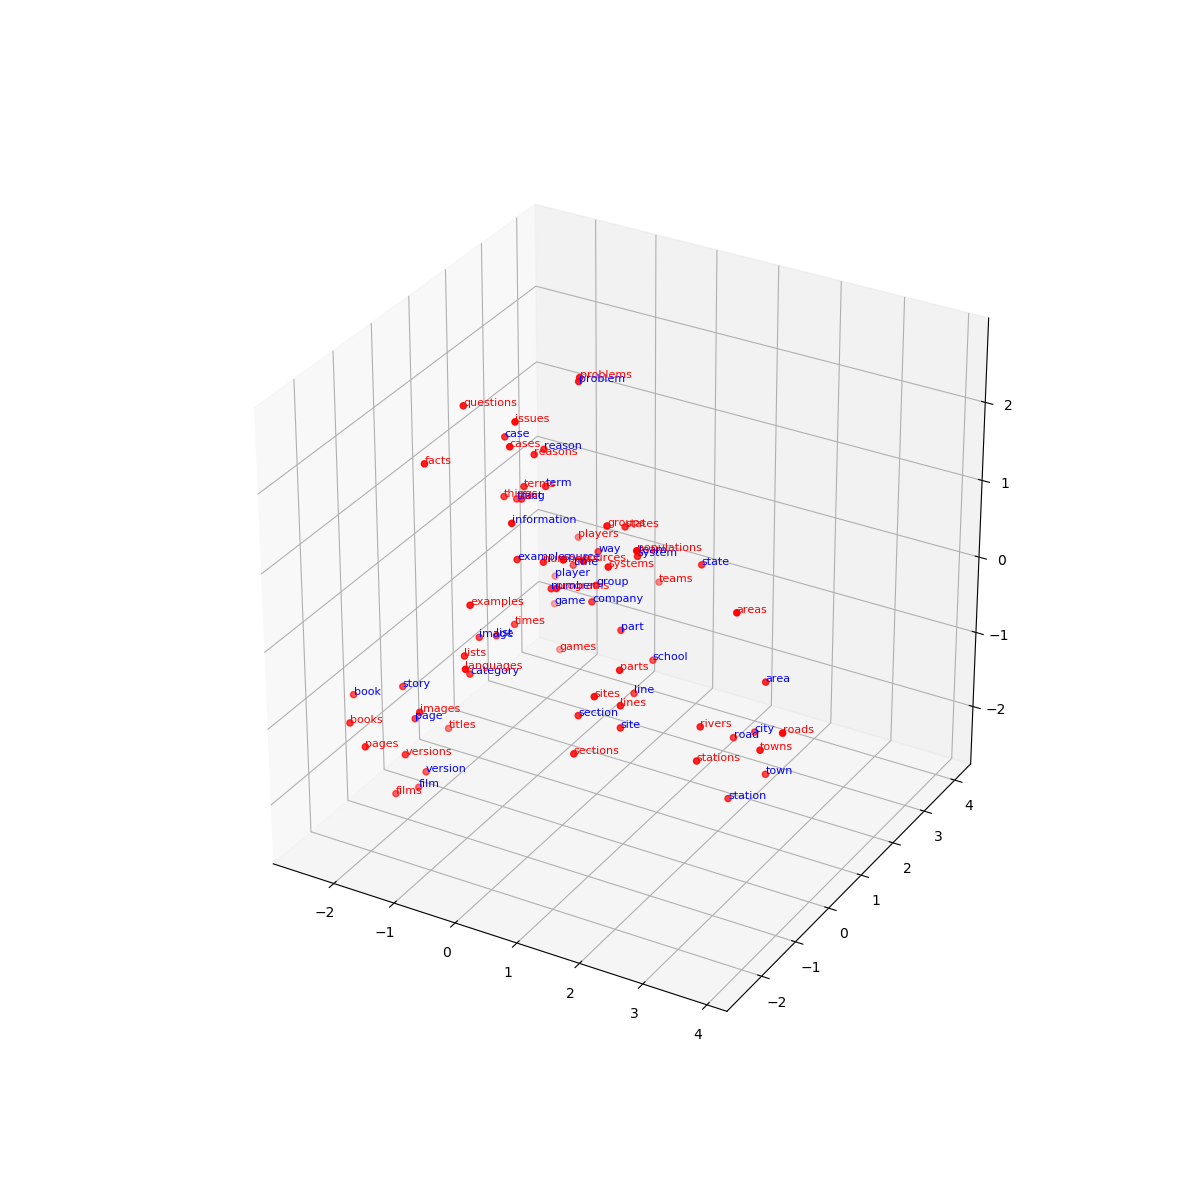

In [219]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(12,12))
idx = []
sents = load_lm_np_dataset(data_folder + '/wiki-train.txt')
S_train = docs_to_indices(sents, word_to_num, 0, 0)
X_train, D_train = seqs_to_lmnpXY(S_train)
from collections import Counter
words = nn[3:40] + nnp[3:40]
ids = list(map(lambda x: word_to_num.get(x), words))
arr = embedding_matrix[np.array(ids),:]
tsne = PCA(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:,0], Y[:,1], Y[:,2],
           color=color, marker='o')
for label, x, y, z in zip(words, Y[:,0],Y[:,1],Y[:,2]):
    color = "b"
    if label[-1] == 's':
        color="r"
    ax.text(x,y,z,  label, size=8, zorder=1,  color=color) 

plt.savefig("thing1")
plt.show()

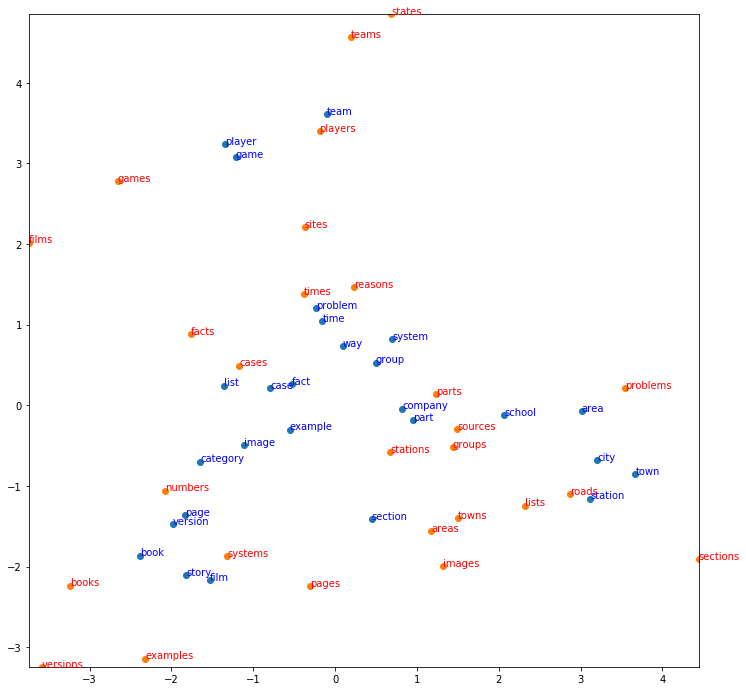

In [178]:


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12,12))
trained_layer = embedding_layer.get_weights()
idx = []
vocab_size = 8000
vocab = pd.read_table(data_folder + "/vocab.wiki.txt", header=None, sep="\s+", index_col=0, names=['count', 'freq'], )
num_to_word = dict(enumerate(vocab.index[:vocab_size]))
word_to_num = invert_dict(num_to_word)
sents = load_lm_np_dataset(data_folder + '/wiki-train.txt')
S_train = docs_to_indices(sents, word_to_num, 0, 0)
X_train, D_train = seqs_to_lmnpXY(S_train)
from collections import Counter
#words =list(map(lambda x: num_to_word.get(x[0],5), Counter(np.concatenate(x_train).ravel()).most_common(200)))
words = nn[3:30]
ids = list(map(lambda x: word_to_num.get(x), words))
arr = trained_layer[0][np.array(ids),:]
tsne = PCA(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)


for label, x, y in zip(words, x_coords, y_coords):
    color = "b"
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', color=color)
words = nnp[3:30]
ids = list(map(lambda x: word_to_num.get(x), words))
arr = trained_layer[0][np.array(ids),:]
tsne = PCA(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
x_coords = x_coords+Y[:, 0]
y_coords = y_coords +Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)


for label, x, y in zip(words, x_coords, y_coords):
    color = "r"
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', color=color)

plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
#plt.title("Embeddings matrix trained for agreement binary prediction task, most common 50 verbs")
plt.show()